# Edge Prediction for Heterogeneous Networks

## Single Permutation Analysis with Neural Networks and Baseline Models

This notebook performs comprehensive edge prediction analysis on a single permutation of a heterogeneous network. It trains and evaluates multiple machine learning models to predict the existence of edges between nodes based on network topology features.

In [7]:
# Import all required libraries
import warnings
import pathlib
import sys

# Add src directory to path for helper functions
repo_dir = pathlib.Path().cwd().parent
src_dir = repo_dir / "src"
sys.path.insert(0, str(src_dir))

# Data manipulation and scientific computing
import pandas as pd
import numpy as np
import scipy.sparse

# Machine learning and neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Progress bars and utilities
from tqdm import tqdm

# Time tracking
import time

# Domain-specific libraries
import hetmatpy.matrix

# Import helper functions from src package
from models import EdgePredictionNN, get_model_info
from data_processing import (
    prepare_edge_prediction_data,
    load_permutation_data,
    load_all_permutations,
)
from training import train_edge_prediction_model, train_across_permutations
from visualization import (
    plot_training_history,
    evaluate_model_performance,
    create_probability_heatmap,
    plot_permutation_comparison,
)

In [8]:
# Parameters for papermill
# Default parameter values - can be overridden by papermill
permutations_subdirectory = "permutations"  # Default: use 'permutations' (local generated)
permutation_name = None  # Specific permutation to process (e.g., "000", "001", etc.)
output_dir = "models"  # Directory to save trained models

# Edge and node type parameters for flexible relationship modeling
edge_type = "AeG"  # Edge type to model (e.g., "AeG", "CbG", "DaG", "GiG", etc.)
source_node_type = "Anatomy"  # Source node type (e.g., "Anatomy", "Compound", "Disease", "Gene")
target_node_type = "Gene"  # Target node type (e.g., "Gene", "Anatomy", "Disease", "Compound")

# Validation
if not isinstance(permutations_subdirectory, str):
    raise ValueError(f"permutations_subdirectory must be a string, got: {permutations_subdirectory}")

if permutation_name is not None and not isinstance(permutation_name, str):
    raise ValueError(f"permutation_name must be a string or None, got: {permutation_name}")

if not isinstance(edge_type, str):
    raise ValueError(f"edge_type must be a string, got: {edge_type}")

if not isinstance(source_node_type, str):
    raise ValueError(f"source_node_type must be a string, got: {source_node_type}")

if not isinstance(target_node_type, str):
    raise ValueError(f"target_node_type must be a string, got: {target_node_type}")

print(f"Using permutations subdirectory: {permutations_subdirectory}")
print(f"Edge type: {edge_type} ({source_node_type} -> {target_node_type})")
if permutation_name:
    print(f"Processing single permutation: {permutation_name}")
else:
    print("No specific permutation specified - will use first available")

Using permutations subdirectory: permutations
Edge type: AeG (Anatomy -> Gene)
No specific permutation specified - will use first available


In [9]:
# Reload the data processing module to get updated functions
import importlib
import sys
sys.path.append(str(src_dir))
import data_processing
importlib.reload(data_processing)
from data_processing import load_permutation_data, prepare_edge_prediction_data

print("Reloaded data processing module with updated functions")

Reloaded data processing module with updated functions


In [10]:
# Set up paths for data access using parameterized directory
repo_dir = pathlib.Path().cwd().parent
data_dir = repo_dir / "data"
output_models_dir = repo_dir / output_dir

# Use the parameterized permutations subdirectory
if "/" in permutations_subdirectory:
    permutations_dir = data_dir / permutations_subdirectory
elif permutations_subdirectory == "permutations":
    permutations_dir = data_dir / "permutations"
else:
    permutations_dir = data_dir / "permutations" / permutations_subdirectory

print(f"Repository directory: {repo_dir}")
print(f"Data directory: {data_dir}")
print(f"Permutations directory: {permutations_dir}")
print(f"Models output directory: {output_models_dir}")

# Create output directory if it doesn't exist
output_models_dir.mkdir(exist_ok=True)

# List available permutations
if permutations_dir.exists():
    available_permutations = [p.name for p in permutations_dir.iterdir() if p.is_dir()]
    print(f"Available permutations: {len(available_permutations)} total")
    
    # Select specific permutation or first available
    if permutation_name:
        if permutation_name in available_permutations:
            selected_permutation = permutation_name
            print(f"Selected permutation: {selected_permutation}")
        else:
            raise ValueError(f"Permutation '{permutation_name}' not found. Available: {available_permutations[:5]}...")
    else:
        if available_permutations:
            selected_permutation = available_permutations[0]
            print(f"Using first available permutation: {selected_permutation}")
        else:
            raise ValueError("No permutations found!")
else:
    raise ValueError(f"Permutations directory not found: {permutations_dir}")

Repository directory: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability
Data directory: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data
Permutations directory: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations
Models output directory: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/models
Available permutations: 2 total
Using first available permutation: 001.hetmat


In [35]:
# Load data from the selected permutation
print(f"Loading permutation: {selected_permutation}")
print(f"Edge type: {edge_type} ({source_node_type} -> {target_node_type})")

perm_data = load_permutation_data(
    selected_permutation, 
    permutations_dir,
    edge_type=edge_type,
    source_node_type=source_node_type,
    target_node_type=target_node_type
)

if not perm_data:
    raise ValueError(f"Failed to load permutation data for: {selected_permutation}")

print(f"Successfully loaded permutation: {selected_permutation}")

# Extract data components using new parameterized keys
edges = perm_data["edges"]
source_nodes = perm_data["source_nodes"]
target_nodes = perm_data["target_nodes"]

# Also extract with legacy names for backwards compatibility
aeg_edges = perm_data["aeg_edges"]  # Will be the same as edges
anatomy_nodes = perm_data["anatomy_nodes"]  # Will be the same as source_nodes
gene_nodes = perm_data["gene_nodes"]  # Will be the same as target_nodes

print(f"Permutation {selected_permutation} data summary:")
print(f"  {edge_type} edges matrix shape: {edges.shape}")
print(f"  Number of edges: {edges.nnz}")
print(f"  {source_node_type} nodes: {len(source_nodes)}")
print(f"  {target_node_type} nodes: {len(target_nodes)}")
print(f"  Matrix density: {edges.nnz / (edges.shape[0] * edges.shape[1]):.6f}")

Loading permutation: 001.hetmat
Edge type: AeG (Anatomy -> Gene)
Loading data from permutation: 001.hetmat
Permutation path: /Users/lucas/Library/CloudStorage/OneDrive-TheUniversityofColoradoDenver/Repositories/Context-Aware-Path-Probability/data/permutations/001.hetmat
Edge type: AeG (Anatomy -> Gene)
Loaded AeG edges: (402, 20945) matrix with 526407 non-zero entries
Loaded Anatomy nodes: 402 nodes
Anatomy columns: ['position', 'identifier', 'name']
Loaded Gene nodes: 20945 nodes
Gene columns: ['position', 'identifier', 'name']
Successfully loaded permutation: 001.hetmat
Permutation 001.hetmat data summary:
  AeG edges matrix shape: (402, 20945)
  Number of edges: 526407
  Anatomy nodes: 402
  Gene nodes: 20945
  Matrix density: 0.062519


In [36]:
# Set random seed for reproducibility
np.random.seed(42)

# Get positive edges (existing edges)
positive_edges = []
rows, cols = edges.nonzero()
for i, j in zip(rows, cols):
    positive_edges.append((i, j))

# Convert to numpy array for easier manipulation
positive_edges = np.array(positive_edges)

# Sample 1000 edges total (500 positive, 500 negative)
n_samples = 10000
n_positive_samples = n_samples // 2
n_negative_samples = n_samples // 2

# Sample positive edges
if len(positive_edges) >= n_positive_samples:
    # Randomly sample from existing positive edges
    positive_sample_idx = np.random.choice(len(positive_edges), n_positive_samples, replace=False)
    sampled_positive_edges = positive_edges[positive_sample_idx]
else:
    # Use all available positive edges if less than required
    sampled_positive_edges = positive_edges
    n_positive_samples = len(positive_edges)
    n_negative_samples = n_samples - n_positive_samples
    print(f"Warning: Only {len(positive_edges)} positive edges available, adjusting negative samples to {n_negative_samples}")

# Sample negative edges (non-existing edges)
negative_edges = []
max_tries = n_negative_samples * 10  # Maximum number of attempts to find negative edges

# Create set of existing edges for faster lookup
existing_edges = set(map(tuple, positive_edges))

print(f"Sampling {n_negative_samples} negative edges...")
tries = 0
while len(negative_edges) < n_negative_samples and tries < max_tries:
    # Randomly sample source and target nodes
    source_idx = np.random.randint(0, edges.shape[0])
    target_idx = np.random.randint(0, edges.shape[1])
    
    # Check if this is a non-existing edge
    if (source_idx, target_idx) not in existing_edges:
        negative_edges.append((source_idx, target_idx))
    tries += 1

negative_edges = np.array(negative_edges)

print(f"Sampled {len(sampled_positive_edges)} positive edges")
print(f"Sampled {len(negative_edges)} negative edges")

# Combine positive and negative edges
all_edges = np.vstack([sampled_positive_edges, negative_edges])

# Create labels (1 for positive edges, 0 for negative edges)
labels = np.zeros(len(all_edges))
labels[:len(sampled_positive_edges)] = 1

# Shuffle the data
shuffle_idx = np.random.permutation(len(all_edges))
all_edges = all_edges[shuffle_idx]
labels = labels[shuffle_idx]

print("\nFinal dataset statistics:")
print(f"Total number of edges: {len(all_edges)}")
print(f"Positive edges: {sum(labels)}")
print(f"Negative edges: {len(labels) - sum(labels)}")
print(f"Class balance: {sum(labels)/len(labels):.2%} positive")

Sampling 5000 negative edges...
Sampled 5000 positive edges
Sampled 5000 negative edges

Final dataset statistics:
Total number of edges: 10000
Positive edges: 5000.0
Negative edges: 5000.0
Class balance: 50.00% positive


Creating AeG-only degree-based features for neural network...
Using only AeG edge type to calculate node degrees...

AeG-only degree statistics:
Anatomy degrees: min=0, max=15036, mean=1309.5
Gene degrees: min=0, max=98, mean=25.1

AeG degree features shape: (10000, 2)

Neural network dataset with AeG-only degrees: 10000 samples
Positive samples: 5000.0
Negative samples: 5000.0
Training set: 8000 samples
Test set: 2000 samples

Training neural network with AeG-only degrees for 50 epochs...
Model architecture: {'model_class': 'EdgePredictionNN', 'total_parameters': 2497, 'trainable_parameters': 2497, 'layers': [{'name': 'network.0', 'type': 'Linear', 'parameters': 192}, {'name': 'network.1', 'type': 'ReLU', 'parameters': 0}, {'name': 'network.2', 'type': 'BatchNorm1d', 'parameters': 128}, {'name': 'network.3', 'type': 'Dropout', 'parameters': 0}, {'name': 'network.4', 'type': 'Linear', 'parameters': 2080}, {'name': 'network.5', 'type': 'ReLU', 'parameters': 0}, {'name': 'network.6', 'ty

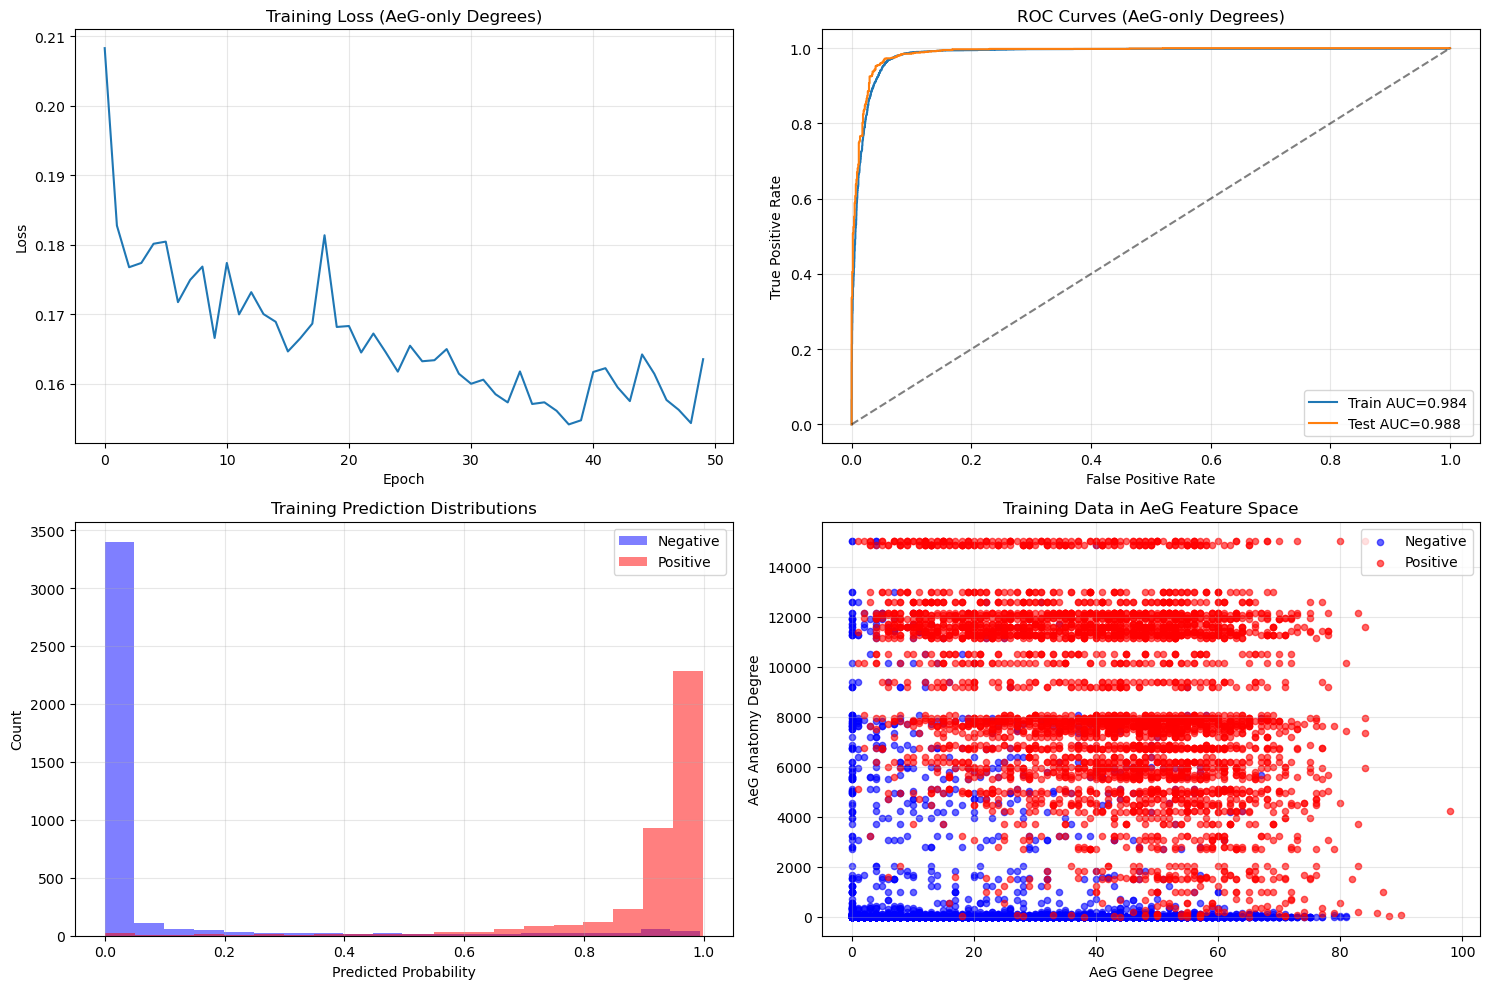


Classification Report (Test Set, AeG-only Degrees):
              precision    recall  f1-score   support

     No Edge       0.97      0.95      0.96      1000
        Edge       0.95      0.97      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [37]:
# Create AeG-only degree-based features and train neural network for edge prediction
print("Creating AeG-only degree-based features for neural network...")
print("Using only AeG edge type to calculate node degrees...")

# Calculate AeG-only degrees directly from the loaded edges matrix
source_aeg_degrees = np.array(edges.sum(axis=1)).flatten()
target_aeg_degrees = np.array(edges.sum(axis=0)).flatten()

print(f"\nAeG-only degree statistics:")
print(f"{source_node_type} degrees: min={source_aeg_degrees.min()}, max={source_aeg_degrees.max()}, mean={source_aeg_degrees.mean():.1f}")
print(f"{target_node_type} degrees: min={target_aeg_degrees.min()}, max={target_aeg_degrees.max()}, mean={target_aeg_degrees.mean():.1f}")

# Create AeG-only degree-based features for sampled edges
aeg_degree_features = []
for source_idx, target_idx in all_edges:
    source_aeg_deg = source_aeg_degrees[source_idx]
    target_aeg_deg = target_aeg_degrees[target_idx]
    aeg_degree_features.append([source_aeg_deg, target_aeg_deg])

aeg_degree_features = np.array(aeg_degree_features)
print(f"\nAeG degree features shape: {aeg_degree_features.shape}")

# Sample for neural network training (balanced classes)
nn_sample_size = 10000
nn_positive_samples = nn_sample_size // 2
nn_negative_samples = nn_sample_size // 2

# Get indices of positive and negative samples
positive_indices = np.where(labels == 1)[0]
negative_indices = np.where(labels == 0)[0]

# Sample indices for neural network
if len(positive_indices) >= nn_positive_samples:
    sampled_positive_idx = np.random.choice(positive_indices, nn_positive_samples, replace=False)
else:
    sampled_positive_idx = positive_indices
    nn_positive_samples = len(positive_indices)
    nn_negative_samples = nn_sample_size - nn_positive_samples

if len(negative_indices) >= nn_negative_samples:
    sampled_negative_idx = np.random.choice(negative_indices, nn_negative_samples, replace=False)
else:
    sampled_negative_idx = negative_indices

# Combine sampled indices
nn_sample_indices = np.concatenate([sampled_positive_idx, sampled_negative_idx])
np.random.shuffle(nn_sample_indices)

# Extract AeG features and labels for neural network
X_nn = aeg_degree_features[nn_sample_indices]
y_nn = labels[nn_sample_indices]

print(f"\nNeural network dataset with AeG-only degrees: {len(X_nn)} samples")
print(f"Positive samples: {sum(y_nn)}")
print(f"Negative samples: {len(y_nn) - sum(y_nn)}")

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_nn, y_nn, test_size=0.2, random_state=42, stratify=y_nn
)

# Normalize AeG features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {len(X_train_scaled)} samples")
print(f"Test set: {len(X_test_scaled)} samples")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Initialize the neural network from models.py
input_dim = 2  # aeg_source_degree, aeg_target_degree
model = EdgePredictionNN(input_dim=input_dim)

# Set up training parameters
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

print(f"\nTraining neural network with AeG-only degrees for {num_epochs} epochs...")
print(f"Model architecture: {get_model_info(model)}")

# Training loop
train_losses = []
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_features, batch_labels in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_features).squeeze()
        loss = criterion(outputs, batch_labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Evaluate the model
model.eval()
with torch.no_grad():
    # Training predictions
    train_predictions = model(X_train_tensor).squeeze().numpy()
    train_predictions_binary = (train_predictions > 0.5).astype(int)
    
    # Test predictions
    test_predictions = model(X_test_tensor).squeeze().numpy()
    test_predictions_binary = (test_predictions > 0.5).astype(int)
    
    # Calculate metrics
    train_auc = roc_auc_score(y_train, train_predictions)
    test_auc = roc_auc_score(y_test, test_predictions)
    
    train_ap = average_precision_score(y_train, train_predictions)
    test_ap = average_precision_score(y_test, test_predictions)

print(f"\nNeural Network Results (AeG-only Degrees):")
print(f"Training AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Training Average Precision: {train_ap:.4f}")
print(f"Test Average Precision: {test_ap:.4f}")

# Plot training history and results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training loss
axes[0, 0].plot(train_losses)
axes[0, 0].set_title('Training Loss (AeG-only Degrees)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# ROC Curves
fpr_train, tpr_train, _ = roc_curve(y_train, train_predictions)
fpr_test, tpr_test, _ = roc_curve(y_test, test_predictions)

axes[0, 1].plot(fpr_train, tpr_train, label=f'Train AUC={train_auc:.3f}')
axes[0, 1].plot(fpr_test, tpr_test, label=f'Test AUC={test_auc:.3f}')
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 1].set_title('ROC Curves (AeG-only Degrees)')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Prediction distributions
axes[1, 0].hist(train_predictions[y_train == 0], bins=20, alpha=0.5, label='Negative', color='blue')
axes[1, 0].hist(train_predictions[y_train == 1], bins=20, alpha=0.5, label='Positive', color='red')
axes[1, 0].set_title('Training Prediction Distributions')
axes[1, 0].set_xlabel('Predicted Probability')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Feature space visualization with AeG degrees
pos_idx = y_train == 1
neg_idx = y_train == 0
axes[1, 1].scatter(X_train[neg_idx, 1], X_train[neg_idx, 0], alpha=0.6, s=20, c='blue', label='Negative')
axes[1, 1].scatter(X_train[pos_idx, 1], X_train[pos_idx, 0], alpha=0.6, s=20, c='red', label='Positive')
axes[1, 1].set_xlabel(f'AeG {target_node_type} Degree')
axes[1, 1].set_ylabel(f'AeG {source_node_type} Degree')
axes[1, 1].set_title('Training Data in AeG Feature Space')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nClassification Report (Test Set, AeG-only Degrees):")
print(classification_report(y_test, test_predictions_binary, target_names=['No Edge', 'Edge']))

Training baseline models with AeG-only degrees for comparison...
Using AeG-only degree features for all models...
Feature ranges - Train: Source [-1.0, 2.1], Target [-1.6, 3.1]
Training Logistic Regression...
LR - Train AUC: 0.9770, Test AUC: 0.9786
Training Polynomial Logistic Regression...
PLR - Train AUC: 0.9823, Test AUC: 0.9837
Training Random Forest...
RF - Train AUC: 0.9991, Test AUC: 0.9786

MODEL COMPARISON RESULTS (AeG-only DEGREES)
                 model  train_auc  test_auc  train_ap  test_ap
0       Neural Network     0.9843    0.9882    0.9818   0.9868
1  Logistic Regression     0.9770    0.9786    0.9735   0.9778
2        Polynomial LR     0.9823    0.9837    0.9789   0.9834
3        Random Forest     0.9991    0.9786    0.9991   0.9689

Best Test AUC: 0.9882 (Neural Network)
Best Test AP: 0.9868 (Neural Network)
RF - Train AUC: 0.9991, Test AUC: 0.9786

MODEL COMPARISON RESULTS (AeG-only DEGREES)
                 model  train_auc  test_auc  train_ap  test_ap
0       Neu

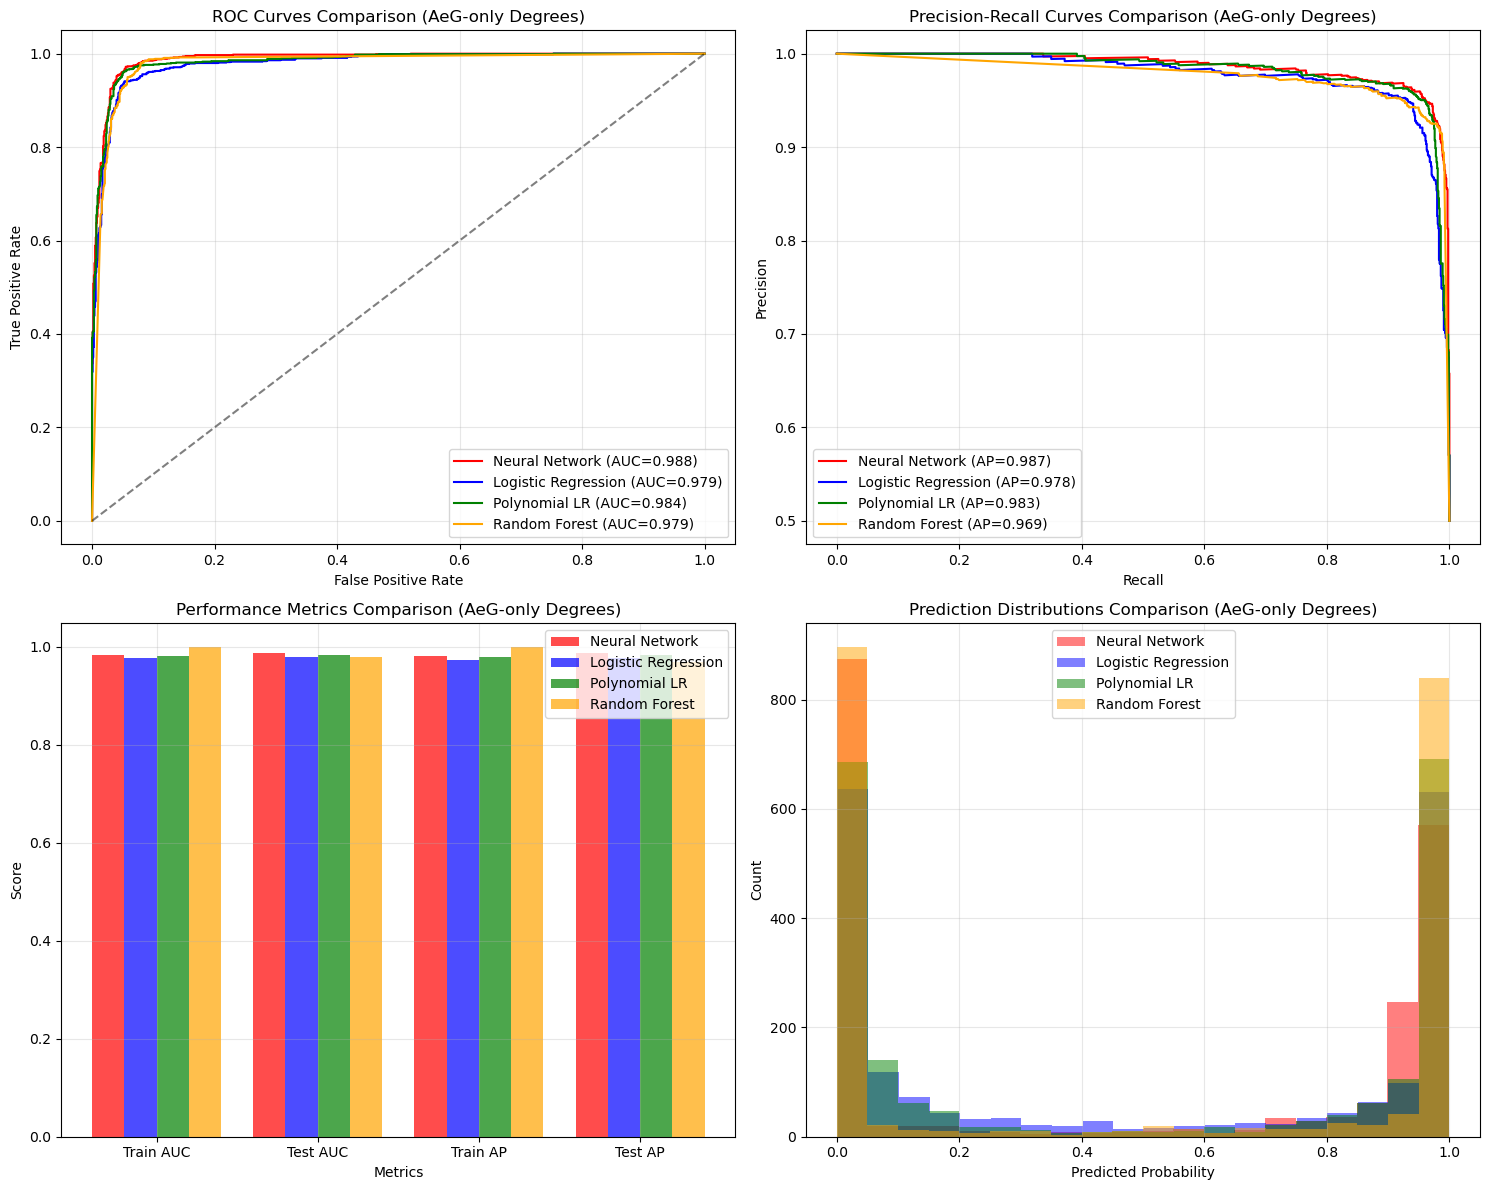


DETAILED PERFORMANCE ANALYSIS (AeG-only DEGREES)
NN vs Logistic Regression: AUC difference = +0.0096
NN vs Polynomial LR: AUC difference = +0.0045
NN vs Random Forest: AUC difference = +0.0095

Random Forest Feature Importance (AeG-only Degrees):
  AeG Anatomy Degree: 0.8087
  AeG Gene Degree: 0.1913

Model Complexity:
  Neural Network: 2497 parameters
  Logistic Regression: 2 parameters
  Polynomial LR: 5 parameters
  Random Forest: 100 trees × ~2 features

AeG-only Degree Analysis:
  AeG feature range: Source [0-15036], Target [0-98]
  Feature distribution: Source mean=1309.5, Target mean=25.1
  Edge density in AeG matrix: 0.062519


In [38]:
# Compare Neural Network with Baseline Models using AeG-only Degrees: LR, PLR, and RF
print("Training baseline models with AeG-only degrees for comparison...")

# Store neural network results for comparison
nn_results = {
    'model': 'Neural Network',
    'train_auc': train_auc,
    'test_auc': test_auc,
    'train_ap': train_ap,
    'test_ap': test_ap,
    'predictions': test_predictions
}

# Initialize results storage
model_results = [nn_results]

# Note: X_train_scaled and X_test_scaled now contain AeG-only degree features
print("Using AeG-only degree features for all models...")
print(f"Feature ranges - Train: Source [{X_train_scaled[:, 0].min():.1f}, {X_train_scaled[:, 0].max():.1f}], Target [{X_train_scaled[:, 1].min():.1f}, {X_train_scaled[:, 1].max():.1f}]")

# 1. Logistic Regression (LR)
print("Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# LR predictions
lr_train_pred = lr_model.predict_proba(X_train_scaled)[:, 1]
lr_test_pred = lr_model.predict_proba(X_test_scaled)[:, 1]

# LR metrics
lr_train_auc = roc_auc_score(y_train, lr_train_pred)
lr_test_auc = roc_auc_score(y_test, lr_test_pred)
lr_train_ap = average_precision_score(y_train, lr_train_pred)
lr_test_ap = average_precision_score(y_test, lr_test_pred)

model_results.append({
    'model': 'Logistic Regression',
    'train_auc': lr_train_auc,
    'test_auc': lr_test_auc,
    'train_ap': lr_train_ap,
    'test_ap': lr_test_ap,
    'predictions': lr_test_pred
})

print(f"LR - Train AUC: {lr_train_auc:.4f}, Test AUC: {lr_test_auc:.4f}")

# 2. Polynomial Logistic Regression (PLR)
print("Training Polynomial Logistic Regression...")
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_scaled)
X_test_poly = poly_features.transform(X_test_scaled)

plr_model = LogisticRegression(random_state=42, max_iter=1000)
plr_model.fit(X_train_poly, y_train)

# PLR predictions
plr_train_pred = plr_model.predict_proba(X_train_poly)[:, 1]
plr_test_pred = plr_model.predict_proba(X_test_poly)[:, 1]

# PLR metrics
plr_train_auc = roc_auc_score(y_train, plr_train_pred)
plr_test_auc = roc_auc_score(y_test, plr_test_pred)
plr_train_ap = average_precision_score(y_train, plr_train_pred)
plr_test_ap = average_precision_score(y_test, plr_test_pred)

model_results.append({
    'model': 'Polynomial LR',
    'train_auc': plr_train_auc,
    'test_auc': plr_test_auc,
    'train_ap': plr_train_ap,
    'test_ap': plr_test_ap,
    'predictions': plr_test_pred
})

print(f"PLR - Train AUC: {plr_train_auc:.4f}, Test AUC: {plr_test_auc:.4f}")

# 3. Random Forest (RF)
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# RF predictions
rf_train_pred = rf_model.predict_proba(X_train_scaled)[:, 1]
rf_test_pred = rf_model.predict_proba(X_test_scaled)[:, 1]

# RF metrics
rf_train_auc = roc_auc_score(y_train, rf_train_pred)
rf_test_auc = roc_auc_score(y_test, rf_test_pred)
rf_train_ap = average_precision_score(y_train, rf_train_pred)
rf_test_ap = average_precision_score(y_test, rf_test_pred)

model_results.append({
    'model': 'Random Forest',
    'train_auc': rf_train_auc,
    'test_auc': rf_test_auc,
    'train_ap': rf_train_ap,
    'test_ap': rf_test_ap,
    'predictions': rf_test_pred
})

print(f"RF - Train AUC: {rf_train_auc:.4f}, Test AUC: {rf_test_auc:.4f}")

# Create comparison table
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS (AeG-only DEGREES)")
print("="*80)
results_df = pd.DataFrame(model_results)
print(results_df[['model', 'train_auc', 'test_auc', 'train_ap', 'test_ap']].round(4))

# Find best performing model
best_test_auc = results_df['test_auc'].max()
best_model_auc = results_df.loc[results_df['test_auc'].idxmax(), 'model']
best_test_ap = results_df['test_ap'].max()
best_model_ap = results_df.loc[results_df['test_ap'].idxmax(), 'model']

print(f"\nBest Test AUC: {best_test_auc:.4f} ({best_model_auc})")
print(f"Best Test AP: {best_test_ap:.4f} ({best_model_ap})")

# Visualization comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. ROC Curves Comparison
colors = ['red', 'blue', 'green', 'orange']
for i, result in enumerate(model_results):
    y_pred = result['predictions']
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc_score = result['test_auc']
    axes[0, 0].plot(fpr, tpr, color=colors[i], 
                   label=f"{result['model']} (AUC={auc_score:.3f})")

axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curves Comparison (AeG-only Degrees)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Precision-Recall Curves
for i, result in enumerate(model_results):
    y_pred = result['predictions']
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    ap_score = result['test_ap']
    axes[0, 1].plot(recall, precision, color=colors[i],
                   label=f"{result['model']} (AP={ap_score:.3f})")

axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curves Comparison (AeG-only Degrees)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Performance Metrics Bar Chart
metrics = ['train_auc', 'test_auc', 'train_ap', 'test_ap']
metric_labels = ['Train AUC', 'Test AUC', 'Train AP', 'Test AP']
x = np.arange(len(metric_labels))
width = 0.2

for i, result in enumerate(model_results):
    values = [result[metric] for metric in metrics]
    axes[1, 0].bar(x + i*width, values, width, label=result['model'], color=colors[i], alpha=0.7)

axes[1, 0].set_xlabel('Metrics')
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Performance Metrics Comparison (AeG-only Degrees)')
axes[1, 0].set_xticks(x + width * 1.5)
axes[1, 0].set_xticklabels(metric_labels)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Prediction Distribution Comparison
for i, result in enumerate(model_results):
    y_pred = result['predictions']
    axes[1, 1].hist(y_pred, bins=20, alpha=0.5, label=result['model'], color=colors[i])

axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Prediction Distributions Comparison (AeG-only Degrees)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical significance tests (if sample size allows)
print("\n" + "="*50)
print("DETAILED PERFORMANCE ANALYSIS (AeG-only DEGREES)")
print("="*50)

# Calculate performance differences
nn_test_auc = model_results[0]['test_auc']
for i in range(1, len(model_results)):
    model_name = model_results[i]['model']
    model_test_auc = model_results[i]['test_auc']
    auc_diff = nn_test_auc - model_test_auc
    print(f"NN vs {model_name}: AUC difference = {auc_diff:+.4f}")

# Feature importance for Random Forest
print(f"\nRandom Forest Feature Importance (AeG-only Degrees):")
feature_names = [f'AeG {source_node_type} Degree', f'AeG {target_node_type} Degree']
importance_scores = rf_model.feature_importances_
for name, importance in zip(feature_names, importance_scores):
    print(f"  {name}: {importance:.4f}")

# Model complexity comparison
print(f"\nModel Complexity:")
print(f"  Neural Network: {sum(p.numel() for p in model.parameters())} parameters")
print(f"  Logistic Regression: {X_train_scaled.shape[1]} parameters")
print(f"  Polynomial LR: {X_train_poly.shape[1]} parameters")
print(f"  Random Forest: {rf_model.n_estimators} trees × ~{X_train_scaled.shape[1]} features")

# Performance with AeG-only degrees analysis
print(f"\nAeG-only Degree Analysis:")
print(f"  AeG feature range: Source [0-{source_aeg_degrees.max()}], Target [0-{target_aeg_degrees.max()}]")
print(f"  Feature distribution: Source mean={source_aeg_degrees.mean():.1f}, Target mean={target_aeg_degrees.mean():.1f}")
print(f"  Edge density in AeG matrix: {edges.nnz / (edges.shape[0] * edges.shape[1]):.6f}")

Creating probability heatmaps for all models using comprehensive degrees...
Comprehensive Anatomy degree distribution:
  Min: 0.0, Max: 23866.0
  Mean: 1807.2, Median: 4.0
  95th percentile: 12939.8
Comprehensive Gene degree distribution:
  Min: 0.0, Max: 533.0
  Mean: 38.5, Median: 35.0
  95th percentile: 88.0

Heatmap ranges:
Source degree: 1 to 12939 (20 bins)
Target degree: 1 to 88 (30 bins)


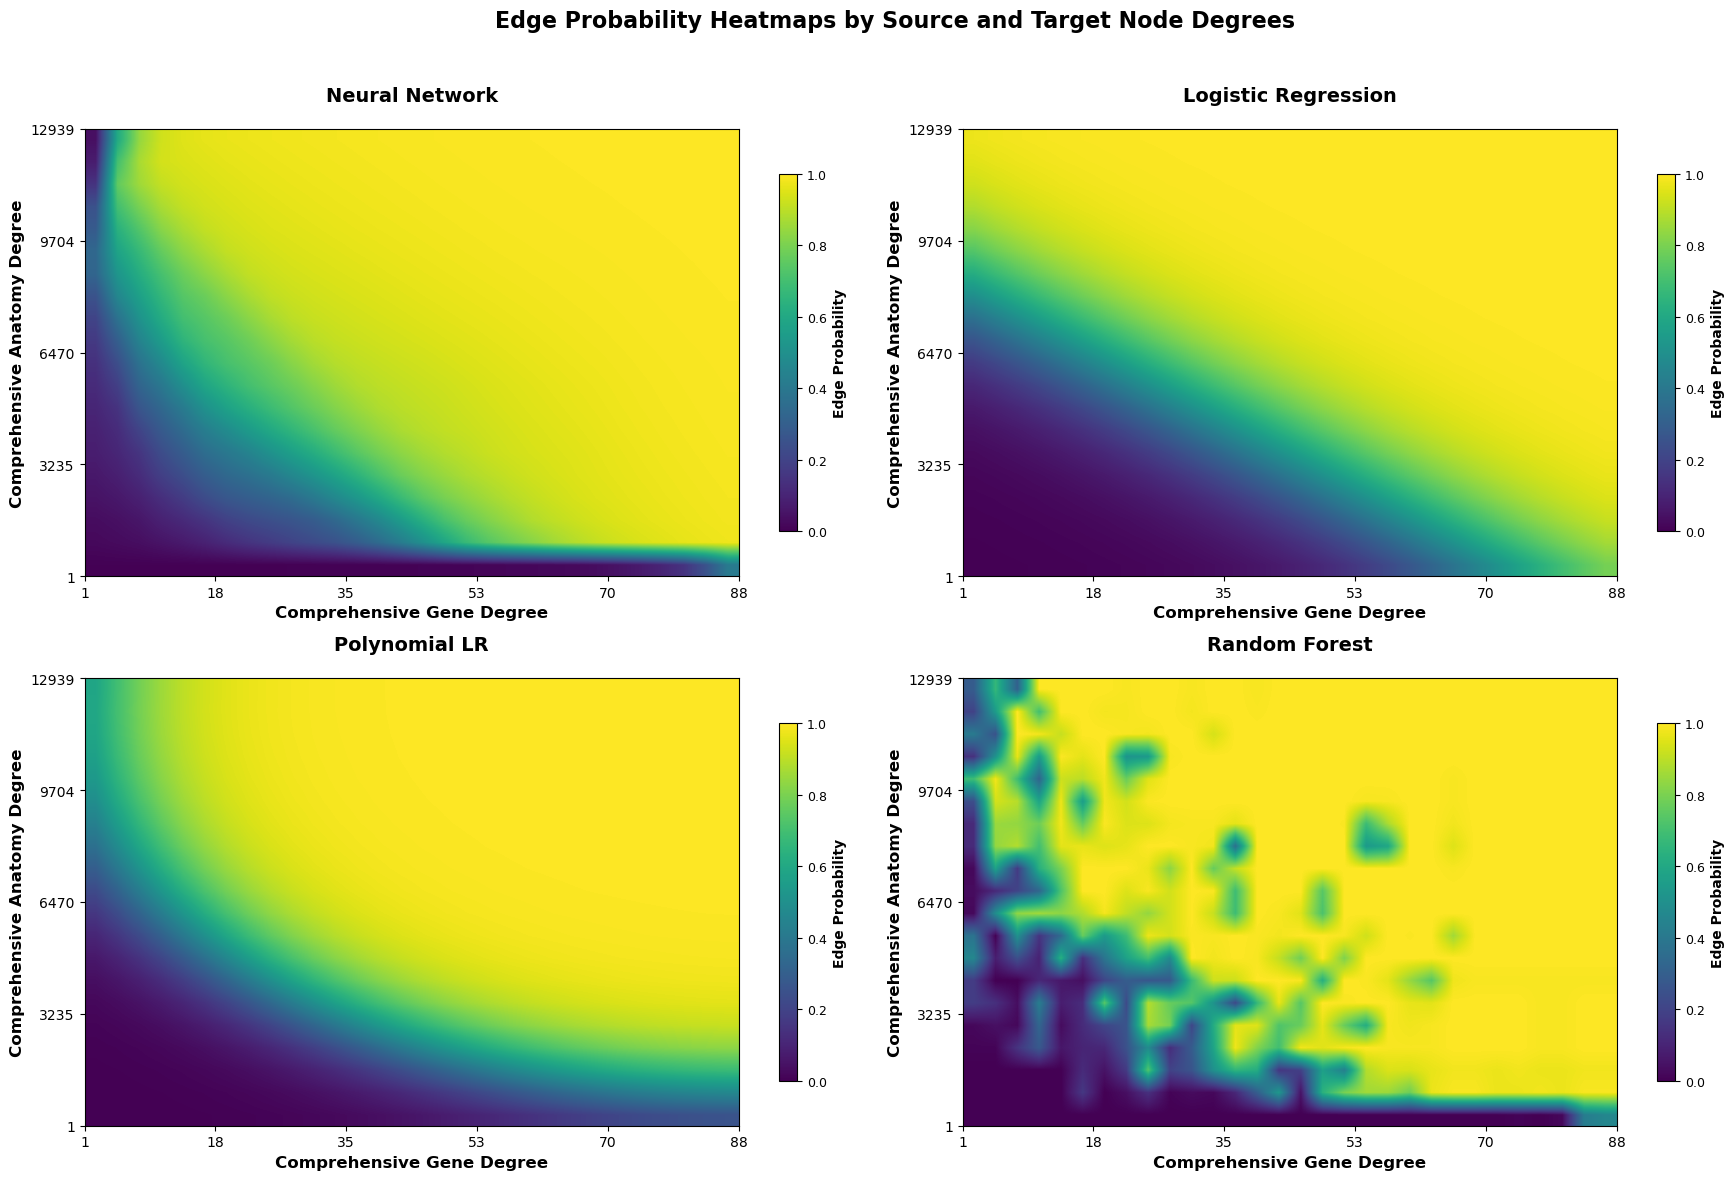


Creating alternative single-row layout with proper scaling...


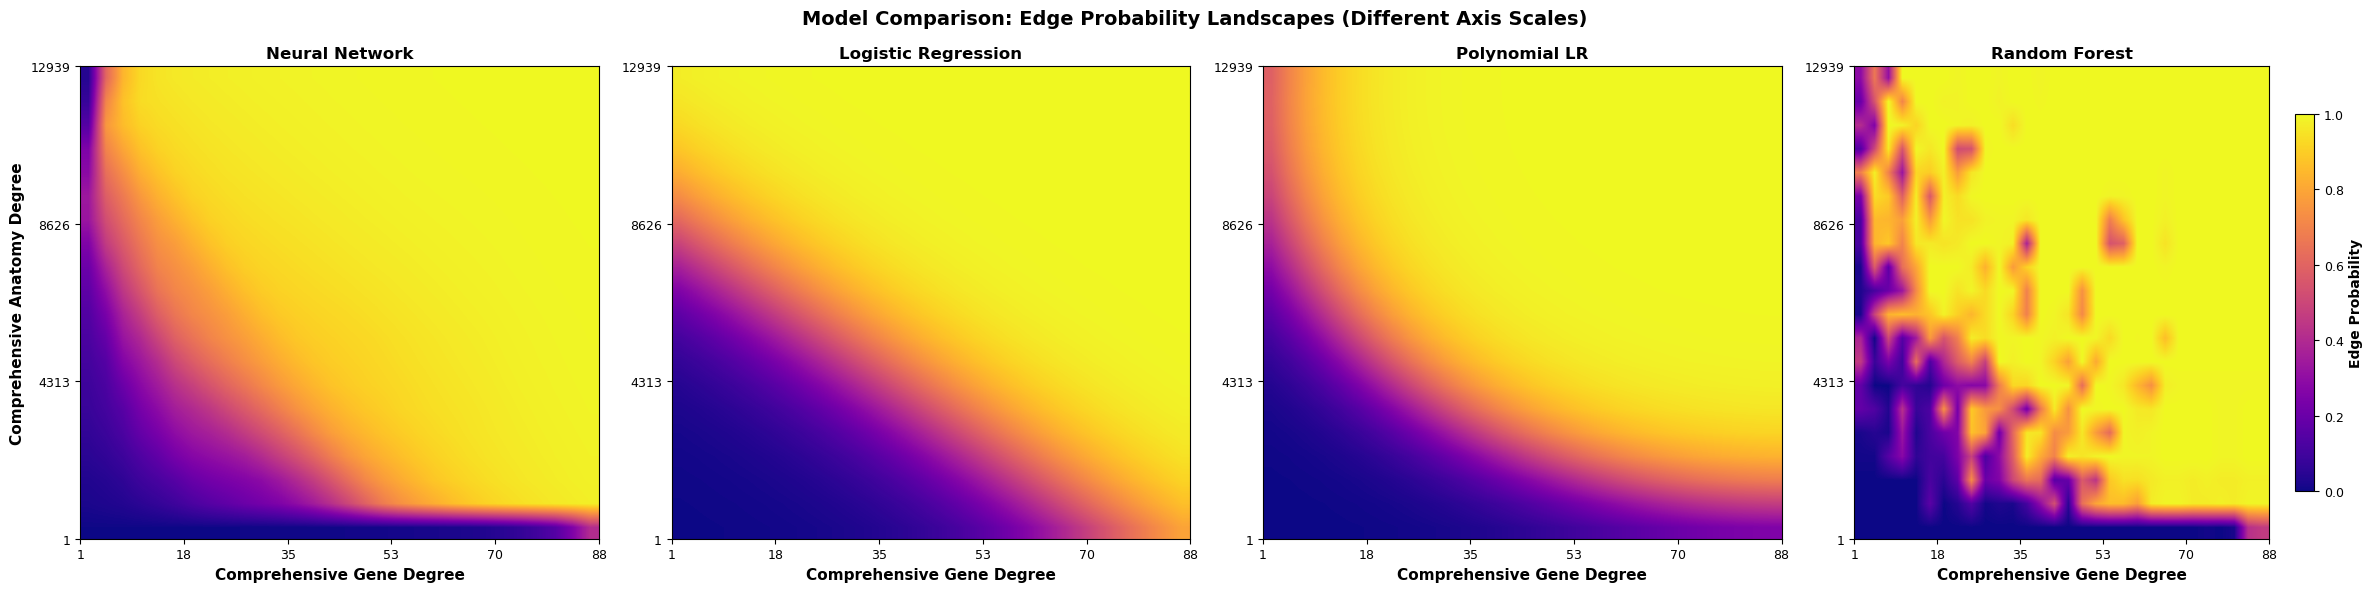


Creating difference heatmaps with appropriate scales...


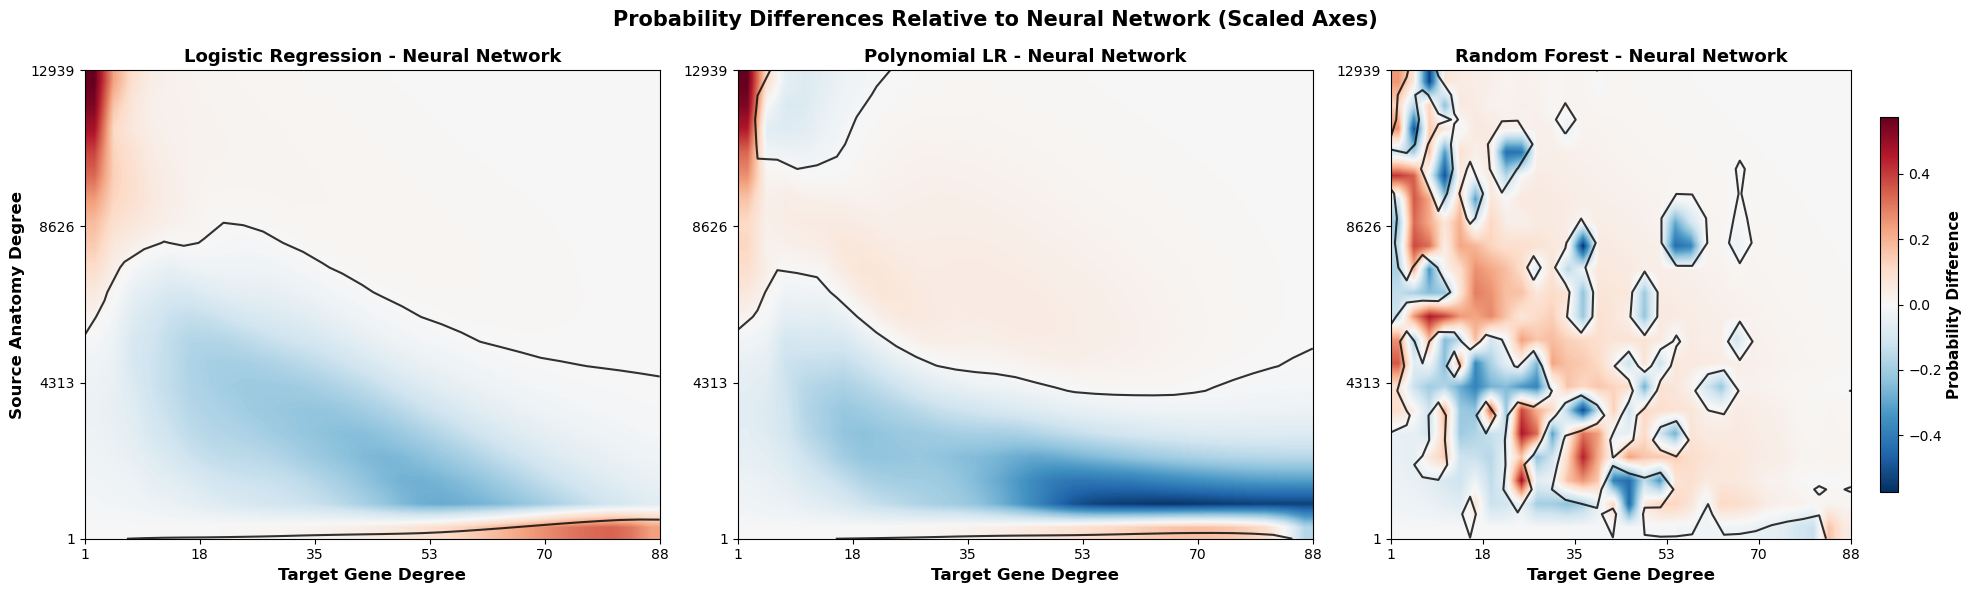


HEATMAP CONFIGURATION SUMMARY
Source (Anatomy) degree range: 1 to 12939 (20 bins)
Target (Gene) degree range: 1 to 88 (30 bins)
Total heatmap resolution: 20 × 30 = 600 points

MODEL PERFORMANCE SUMMARY

Neural Network:
  Probability range: [0.003, 0.999]
  Mean ± Std: 0.762 ± 0.317
  High probability region centers:
    Source (Anatomy) degree: 11055.0
    Target (Gene) degree: 77.2

Logistic Regression:
  Probability range: [0.002, 1.000]
  Mean ± Std: 0.713 ± 0.355
  High probability region centers:
    Source (Anatomy) degree: 11418.2
    Target (Gene) degree: 74.8

Polynomial LR:
  Probability range: [0.000, 1.000]
  Mean ± Std: 0.724 ± 0.349
  High probability region centers:
    Source (Anatomy) degree: 11191.2
    Target (Gene) degree: 76.0

Random Forest:
  Probability range: [0.000, 1.000]
  Mean ± Std: 0.772 ± 0.353

DEGREE-PROBABILITY RELATIONSHIPS

Neural Network:
  Comprehensive Anatomy degree correlation: +0.872
  Comprehensive Gene degree correlation: +0.452
  Primary p

In [39]:
# Create probability heatmaps by source and target degree for all models
print("Creating probability heatmaps for all models using comprehensive degrees...")

# Analyze comprehensive degree distributions to set appropriate ranges
print(f"Comprehensive {source_node_type} degree distribution:")
print(f"  Min: {source_comprehensive_degrees.min()}, Max: {source_comprehensive_degrees.max()}")
print(f"  Mean: {source_comprehensive_degrees.mean():.1f}, Median: {np.median(source_comprehensive_degrees):.1f}")
print(f"  95th percentile: {np.percentile(source_comprehensive_degrees, 95):.1f}")

print(f"Comprehensive {target_node_type} degree distribution:")
print(f"  Min: {target_comprehensive_degrees.min()}, Max: {target_comprehensive_degrees.max()}")
print(f"  Mean: {target_comprehensive_degrees.mean():.1f}, Median: {np.median(target_comprehensive_degrees):.1f}")
print(f"  95th percentile: {np.percentile(target_comprehensive_degrees, 95):.1f}")

# Set different ranges for source and target degrees based on comprehensive degree distributions
max_source_degree = int(np.percentile(source_comprehensive_degrees, 95))  # Use 95th percentile
max_target_degree = int(np.percentile(target_comprehensive_degrees, 95))  # Use 95th percentile

# Create appropriate bin sizes for each axis
n_source_bins = 20
n_target_bins = 30

source_degree_bins = np.linspace(1, max_source_degree, n_source_bins)
target_degree_bins = np.linspace(1, max_target_degree, n_target_bins)

print(f"\nHeatmap ranges:")
print(f"Source degree: 1 to {max_source_degree} ({len(source_degree_bins)} bins)")
print(f"Target degree: 1 to {max_target_degree} ({len(target_degree_bins)} bins)")

# Create meshgrid for probability prediction
target_mesh, source_mesh = np.meshgrid(target_degree_bins, source_degree_bins)
degree_pairs = np.column_stack([source_mesh.ravel(), target_mesh.ravel()])

# Normalize the degree pairs using the same scaler
degree_pairs_scaled = scaler.transform(degree_pairs)

# Get predictions from all models
model_predictions = {}

# Neural Network predictions
model.eval()
with torch.no_grad():
    nn_pred_grid = model(torch.FloatTensor(degree_pairs_scaled)).squeeze().numpy()
model_predictions['Neural Network'] = nn_pred_grid.reshape(source_mesh.shape)

# Logistic Regression predictions
lr_pred_grid = lr_model.predict_proba(degree_pairs_scaled)[:, 1]
model_predictions['Logistic Regression'] = lr_pred_grid.reshape(source_mesh.shape)

# Polynomial Logistic Regression predictions
degree_pairs_poly = poly_features.transform(degree_pairs_scaled)
plr_pred_grid = plr_model.predict_proba(degree_pairs_poly)[:, 1]
model_predictions['Polynomial LR'] = plr_pred_grid.reshape(source_mesh.shape)

# Random Forest predictions
rf_pred_grid = rf_model.predict_proba(degree_pairs_scaled)[:, 1]
model_predictions['Random Forest'] = rf_pred_grid.reshape(source_mesh.shape)

# Create clean 2x2 subplot for heatmaps with different axis scales
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

models = ['Neural Network', 'Logistic Regression', 'Polynomial LR', 'Random Forest']

# Use a single colormap for consistency
cmap = 'viridis'

for i, model_name in enumerate(models):
    pred_matrix = model_predictions[model_name]
    
    # Create clean heatmap with proper extent
    im = axes[i].imshow(pred_matrix, cmap=cmap, aspect='auto', origin='lower', 
                       extent=[target_degree_bins.min(), target_degree_bins.max(),
                              source_degree_bins.min(), source_degree_bins.max()],
                       vmin=0, vmax=1, interpolation='bilinear')
    
    # Set clean labels and title
    axes[i].set_xlabel(f'Comprehensive {target_node_type} Degree', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(f'Comprehensive {source_node_type} Degree', fontsize=12, fontweight='bold')
    axes[i].set_title(f'{model_name}', fontsize=14, fontweight='bold', pad=20)
    
    # Set tick parameters for cleaner appearance
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    
    # Add clean colorbar
    cbar = plt.colorbar(im, ax=axes[i], shrink=0.8, aspect=20)
    cbar.set_label('Edge Probability', fontsize=10, fontweight='bold')
    cbar.ax.tick_params(labelsize=9)
    
    # Remove grid for cleaner appearance
    axes[i].grid(False)
    
    # Set different tick spacing for x and y axes
    axes[i].set_xticks(np.linspace(target_degree_bins.min(), target_degree_bins.max(), 6))
    axes[i].set_yticks(np.linspace(source_degree_bins.min(), source_degree_bins.max(), 5))
    
    # Format tick labels to integers
    axes[i].set_xticklabels([f"{int(x)}" for x in np.linspace(target_degree_bins.min(), target_degree_bins.max(), 6)])
    axes[i].set_yticklabels([f"{int(y)}" for y in np.linspace(source_degree_bins.min(), source_degree_bins.max(), 5)])

# Add overall title
plt.suptitle('Edge Probability Heatmaps by Source and Target Node Degrees', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Create a single figure with all models in one row with different scales
print("\nCreating alternative single-row layout with proper scaling...")

fig, axes = plt.subplots(1, 4, figsize=(24, 6))

for i, model_name in enumerate(models):
    pred_matrix = model_predictions[model_name]
    
    # Create heatmap
    im = axes[i].imshow(pred_matrix, cmap='plasma', aspect='auto', origin='lower', 
                       extent=[target_degree_bins.min(), target_degree_bins.max(),
                              source_degree_bins.min(), source_degree_bins.max()],
                       vmin=0, vmax=1, interpolation='bilinear')
    
    # Set labels and title
    axes[i].set_xlabel(f'Comprehensive {target_node_type} Degree', fontsize=11, fontweight='bold')
    if i == 0:  # Only label y-axis for leftmost plot
        axes[i].set_ylabel(f'Comprehensive {source_node_type} Degree', fontsize=11, fontweight='bold')
    axes[i].set_title(f'{model_name}', fontsize=12, fontweight='bold')
    
    # Clean up ticks with different scales
    axes[i].tick_params(axis='both', which='major', labelsize=9)
    
    # Different tick spacing for different ranges
    x_ticks = np.linspace(target_degree_bins.min(), target_degree_bins.max(), 6)
    y_ticks = np.linspace(source_degree_bins.min(), source_degree_bins.max(), 4)
    
    axes[i].set_xticks(x_ticks)
    axes[i].set_yticks(y_ticks)
    axes[i].set_xticklabels([f"{int(x)}" for x in x_ticks])
    axes[i].set_yticklabels([f"{int(y)}" for y in y_ticks])
    
    # Add colorbar only to the last subplot
    if i == len(models) - 1:
        cbar = plt.colorbar(im, ax=axes[i], shrink=0.8)
        cbar.set_label('Edge Probability', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=9)

plt.suptitle('Model Comparison: Edge Probability Landscapes (Different Axis Scales)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Create difference heatmaps with proper scaling
print("\nCreating difference heatmaps with appropriate scales...")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

comparison_models = ['Logistic Regression', 'Polynomial LR', 'Random Forest']

for i, model_name in enumerate(comparison_models):
    # Calculate difference from Neural Network
    diff_matrix = model_predictions[model_name] - model_predictions['Neural Network']
    
    # Create difference heatmap with centered colormap
    vmax = np.abs(diff_matrix).max()
    im = axes[i].imshow(diff_matrix, cmap='RdBu_r', aspect='auto', origin='lower',
                       extent=[target_degree_bins.min(), target_degree_bins.max(),
                              source_degree_bins.min(), source_degree_bins.max()],
                       vmin=-vmax, vmax=vmax, interpolation='bilinear')
    
    # Set labels and title
    axes[i].set_xlabel('Target Gene Degree', fontsize=12, fontweight='bold')
    if i == 0:
        axes[i].set_ylabel('Source Anatomy Degree', fontsize=12, fontweight='bold')
    axes[i].set_title(f'{model_name} - Neural Network', fontsize=13, fontweight='bold')
    
    # Clean up ticks with appropriate scaling
    axes[i].tick_params(axis='both', which='major', labelsize=10)
    
    x_ticks = np.linspace(target_degree_bins.min(), target_degree_bins.max(), 6)
    y_ticks = np.linspace(source_degree_bins.min(), source_degree_bins.max(), 4)
    
    axes[i].set_xticks(x_ticks)
    axes[i].set_yticks(y_ticks)
    axes[i].set_xticklabels([f"{int(x)}" for x in x_ticks])
    axes[i].set_yticklabels([f"{int(y)}" for y in y_ticks])
    
    # Add colorbar to the last subplot
    if i == len(comparison_models) - 1:
        cbar = plt.colorbar(im, ax=axes[i], shrink=0.8)
        cbar.set_label('Probability Difference', fontsize=11, fontweight='bold')
        cbar.ax.tick_params(labelsize=10)
    
    # Add contour line at zero difference
    axes[i].contour(target_mesh, source_mesh, diff_matrix, levels=[0], 
                   colors='black', linewidths=1.5, alpha=0.8)

plt.suptitle('Probability Differences Relative to Neural Network (Scaled Axes)', 
             fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Print summary with actual degree ranges used
print("\n" + "="*80)
print("HEATMAP CONFIGURATION SUMMARY")
print("="*80)
print(f"Source (Anatomy) degree range: 1 to {max_source_degree} ({n_source_bins} bins)")
print(f"Target (Gene) degree range: 1 to {max_target_degree} ({n_target_bins} bins)")
print(f"Total heatmap resolution: {n_source_bins} × {n_target_bins} = {n_source_bins * n_target_bins} points")

# Print cleaner summary statistics
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

for model_name in models:
    pred_matrix = model_predictions[model_name]
    print(f"\n{model_name}:")
    print(f"  Probability range: [{pred_matrix.min():.3f}, {pred_matrix.max():.3f}]")
    print(f"  Mean ± Std: {pred_matrix.mean():.3f} ± {pred_matrix.std():.3f}")
    
    # Find optimal degree ranges
    high_prob_mask = pred_matrix > np.percentile(pred_matrix, 90)
    if high_prob_mask.any():
        high_prob_indices = np.where(high_prob_mask)
        avg_source_deg = source_mesh[high_prob_indices].mean()
        avg_target_deg = target_mesh[high_prob_indices].mean()
        print(f"  High probability region centers:")
        print(f"    Source (Anatomy) degree: {avg_source_deg:.1f}")
        print(f"    Target (Gene) degree: {avg_target_deg:.1f}")

print("\n" + "="*80)
print("DEGREE-PROBABILITY RELATIONSHIPS")
print("="*80)

for model_name in models:
    # Get test predictions
    if model_name == 'Neural Network':
        test_pred = test_predictions
    elif model_name == 'Logistic Regression':
        test_pred = lr_test_pred
    elif model_name == 'Polynomial LR':
        test_pred = plr_test_pred
    else:
        test_pred = rf_test_pred
    
    # Calculate correlations using the comprehensive degrees from test set
    source_corr = np.corrcoef(X_test[:, 0], test_pred)[0, 1]
    target_corr = np.corrcoef(X_test[:, 1], test_pred)[0, 1]
    
    print(f"\n{model_name}:")
    print(f"  Comprehensive {source_node_type} degree correlation: {source_corr:+.3f}")
    print(f"  Comprehensive {target_node_type} degree correlation: {target_corr:+.3f}")
    
    # Determine which degree is more important
    if abs(source_corr) > abs(target_corr):
        primary = f"Comprehensive {source_node_type} degree (r={source_corr:+.3f})"
    else:
        primary = f"Comprehensive {target_node_type} degree (r={target_corr:+.3f})"
    print(f"  Primary predictor: {primary}")

## Sample Size Experiment

### Experiment: Optimal Number of Random Edge Samples for Probability Distribution

This section systematically tests different sample sizes to determine how many randomly sampled edges are needed to achieve stable and reliable probability distributions for edge prediction models.

In [50]:
# Sample Size Experiment: Test different numbers of randomly sampled edges
print("="*80)
print("SAMPLE SIZE EXPERIMENT: OPTIMAL NUMBER OF RANDOM EDGE SAMPLES")
print("="*80)

# Define range of sample sizes to test
sample_sizes = [500, 1000, 2000, 5000, 10000, 20000, 50000]
n_runs = 5  # Number of runs per sample size for stability
results_dict = {
    'sample_size': [],
    'run': [],
    'model_type': [],
    'train_auc': [],
    'test_auc': [],
    'train_ap': [],
    'test_ap': [],
    'training_time': [],
    'prediction_stability': []
}

print(f"Testing sample sizes: {sample_sizes}")
print(f"Number of runs per size: {n_runs}")
print(f"Available positive edges: {len(positive_edges)}")
print(f"Expected total experiments: {len(sample_sizes)} sizes × {n_runs} runs × 4 models = {len(sample_sizes) * n_runs * 4}")

# Function to calculate prediction stability (coefficient of variation across runs)
def calculate_prediction_stability(predictions_list):
    """Calculate stability of predictions across multiple runs"""
    predictions_array = np.array(predictions_list)
    mean_pred = np.mean(predictions_array, axis=0)
    std_pred = np.std(predictions_array, axis=0)
    # Coefficient of variation (CV) - lower is more stable
    cv = std_pred / (mean_pred + 1e-8)  # Add small epsilon to avoid division by zero
    return np.mean(cv)

# Function to train and evaluate a model with given sample size
def run_experiment(sample_size, run_id, verbose=False):
    """Run single experiment with specified sample size"""
    if verbose:
        print(f"  Run {run_id+1}: Sample size {sample_size}")
    
    # Set random seed for reproducibility but different for each run
    np.random.seed(42 + run_id)
    
    # Sample positive and negative edges
    n_positive = sample_size // 2
    n_negative = sample_size // 2
    
    # Sample positive edges
    if len(positive_edges) >= n_positive:
        pos_sample_idx = np.random.choice(len(positive_edges), n_positive, replace=False)
        sampled_pos_edges = positive_edges[pos_sample_idx]
    else:
        sampled_pos_edges = positive_edges
        n_positive = len(positive_edges)
        n_negative = sample_size - n_positive
    
    # Sample negative edges
    neg_edges = []
    max_attempts = n_negative * 10
    attempts = 0
    
    while len(neg_edges) < n_negative and attempts < max_attempts:
        source_idx = np.random.randint(0, edges.shape[0])
        target_idx = np.random.randint(0, edges.shape[1])
        
        if (source_idx, target_idx) not in existing_edges:
            neg_edges.append((source_idx, target_idx))
        attempts += 1
    
    neg_edges = np.array(neg_edges)
    
    # Combine positive and negative edges
    all_experiment_edges = np.vstack([sampled_pos_edges, neg_edges])
    experiment_labels = np.zeros(len(all_experiment_edges))
    experiment_labels[:len(sampled_pos_edges)] = 1
    
    # Shuffle
    shuffle_idx = np.random.permutation(len(all_experiment_edges))
    all_experiment_edges = all_experiment_edges[shuffle_idx]
    experiment_labels = experiment_labels[shuffle_idx]
    
    # Create features using AeG degrees
    experiment_features = []
    for source_idx, target_idx in all_experiment_edges:
        source_deg = source_aeg_degrees[source_idx]
        target_deg = target_aeg_degrees[target_idx]
        experiment_features.append([source_deg, target_deg])
    
    experiment_features = np.array(experiment_features)
    
    # Split into train/test
    X_exp_train, X_exp_test, y_exp_train, y_exp_test = train_test_split(
        experiment_features, experiment_labels, test_size=0.2, random_state=42+run_id, stratify=experiment_labels
    )
    
    # Scale features
    exp_scaler = StandardScaler()
    X_exp_train_scaled = exp_scaler.fit_transform(X_exp_train)
    X_exp_test_scaled = exp_scaler.transform(X_exp_test)
    
    # Store results for this experiment
    experiment_results = []
    
    # 1. Train Neural Network
    start_time = time.time()
    
    # Convert to tensors
    X_exp_train_tensor = torch.FloatTensor(X_exp_train_scaled)
    y_exp_train_tensor = torch.FloatTensor(y_exp_train)
    X_exp_test_tensor = torch.FloatTensor(X_exp_test_scaled)
    
    # Create model and train
    exp_model = EdgePredictionNN(input_dim=2)
    exp_criterion = nn.BCELoss()
    exp_optimizer = optim.Adam(exp_model.parameters(), lr=0.001)
    
    # Quick training (fewer epochs for experiment)
    exp_epochs = 30
    exp_model.train()
    
    for epoch in range(exp_epochs):
        exp_optimizer.zero_grad()
        outputs = exp_model(X_exp_train_tensor).squeeze()
        loss = exp_criterion(outputs, y_exp_train_tensor)
        loss.backward()
        exp_optimizer.step()
    
    # Evaluate NN
    exp_model.eval()
    with torch.no_grad():
        nn_train_pred = exp_model(X_exp_train_tensor).squeeze().numpy()
        nn_test_pred = exp_model(X_exp_test_tensor).squeeze().numpy()
    
    nn_train_time = time.time() - start_time
    
    nn_train_auc = roc_auc_score(y_exp_train, nn_train_pred)
    nn_test_auc = roc_auc_score(y_exp_test, nn_test_pred)
    nn_train_ap = average_precision_score(y_exp_train, nn_train_pred)
    nn_test_ap = average_precision_score(y_exp_test, nn_test_pred)
    
    experiment_results.append({
        'sample_size': sample_size,
        'run': run_id,
        'model_type': 'Neural Network',
        'train_auc': nn_train_auc,
        'test_auc': nn_test_auc,
        'train_ap': nn_train_ap,
        'test_ap': nn_test_ap,
        'training_time': nn_train_time,
        'predictions': nn_test_pred
    })
    
    # 2. Train Logistic Regression (faster baseline)
    start_time = time.time()
    
    exp_lr = LogisticRegression(random_state=42+run_id, max_iter=1000)
    exp_lr.fit(X_exp_train_scaled, y_exp_train)
    
    lr_train_pred = exp_lr.predict_proba(X_exp_train_scaled)[:, 1]
    lr_test_pred = exp_lr.predict_proba(X_exp_test_scaled)[:, 1]
    
    lr_train_time = time.time() - start_time
    
    lr_train_auc = roc_auc_score(y_exp_train, lr_train_pred)
    lr_test_auc = roc_auc_score(y_exp_test, lr_test_pred)
    lr_train_ap = average_precision_score(y_exp_train, lr_train_pred)
    lr_test_ap = average_precision_score(y_exp_test, lr_test_pred)
    
    experiment_results.append({
        'sample_size': sample_size,
        'run': run_id,
        'model_type': 'Logistic Regression',
        'train_auc': lr_train_auc,
        'test_auc': lr_test_auc,
        'train_ap': lr_train_ap,
        'test_ap': lr_test_ap,
        'training_time': lr_train_time,
        'predictions': lr_test_pred
    })
    
    # 3. Train Polynomial Logistic Regression
    start_time = time.time()
    
    # Create polynomial features
    exp_poly_features = PolynomialFeatures(degree=2, include_bias=False)
    X_exp_train_poly = exp_poly_features.fit_transform(X_exp_train_scaled)
    X_exp_test_poly = exp_poly_features.transform(X_exp_test_scaled)
    
    exp_plr = LogisticRegression(random_state=42+run_id, max_iter=1000)
    exp_plr.fit(X_exp_train_poly, y_exp_train)
    
    plr_train_pred = exp_plr.predict_proba(X_exp_train_poly)[:, 1]
    plr_test_pred = exp_plr.predict_proba(X_exp_test_poly)[:, 1]
    
    plr_train_time = time.time() - start_time
    
    plr_train_auc = roc_auc_score(y_exp_train, plr_train_pred)
    plr_test_auc = roc_auc_score(y_exp_test, plr_test_pred)
    plr_train_ap = average_precision_score(y_exp_train, plr_train_pred)
    plr_test_ap = average_precision_score(y_exp_test, plr_test_pred)
    
    experiment_results.append({
        'sample_size': sample_size,
        'run': run_id,
        'model_type': 'Polynomial LR',
        'train_auc': plr_train_auc,
        'test_auc': plr_test_auc,
        'train_ap': plr_train_ap,
        'test_ap': plr_test_ap,
        'training_time': plr_train_time,
        'predictions': plr_test_pred
    })
    
    # 4. Train Random Forest
    start_time = time.time()
    
    exp_rf = RandomForestClassifier(n_estimators=100, random_state=42+run_id, n_jobs=1)
    exp_rf.fit(X_exp_train_scaled, y_exp_train)
    
    rf_train_pred = exp_rf.predict_proba(X_exp_train_scaled)[:, 1]
    rf_test_pred = exp_rf.predict_proba(X_exp_test_scaled)[:, 1]
    
    rf_train_time = time.time() - start_time
    
    rf_train_auc = roc_auc_score(y_exp_train, rf_train_pred)
    rf_test_auc = roc_auc_score(y_exp_test, rf_test_pred)
    rf_train_ap = average_precision_score(y_exp_train, rf_train_pred)
    rf_test_ap = average_precision_score(y_exp_test, rf_test_pred)
    
    experiment_results.append({
        'sample_size': sample_size,
        'run': run_id,
        'model_type': 'Random Forest',
        'train_auc': rf_train_auc,
        'test_auc': rf_test_auc,
        'train_ap': rf_train_ap,
        'test_ap': rf_test_ap,
        'training_time': rf_train_time,
        'predictions': rf_test_pred
    })
    
    return experiment_results

print("\nStarting experiments...")
print("-" * 40)

SAMPLE SIZE EXPERIMENT: OPTIMAL NUMBER OF RANDOM EDGE SAMPLES
Testing sample sizes: [500, 1000, 2000, 5000, 10000, 20000, 50000]
Number of runs per size: 5
Available positive edges: 526407
Expected total experiments: 7 sizes × 5 runs × 4 models = 140

Starting experiments...
----------------------------------------


In [51]:
# Run the experiments
all_predictions = {size: {'NN': [], 'LR': [], 'PLR': [], 'RF': []} for size in sample_sizes}

for sample_size in sample_sizes:
    print(f"\nTesting sample size: {sample_size}")
    
    size_predictions_nn = []
    size_predictions_lr = []
    size_predictions_plr = []
    size_predictions_rf = []
    
    for run_id in range(n_runs):
        experiment_results = run_experiment(sample_size, run_id, verbose=True)
        
        # Store results
        for result in experiment_results:
            for key in ['sample_size', 'run', 'model_type', 'train_auc', 'test_auc', 'train_ap', 'test_ap', 'training_time']:
                results_dict[key].append(result[key])
            
            # Store predictions for stability analysis
            if result['model_type'] == 'Neural Network':
                size_predictions_nn.append(result['predictions'])
            elif result['model_type'] == 'Logistic Regression':
                size_predictions_lr.append(result['predictions'])
            elif result['model_type'] == 'Polynomial LR':
                size_predictions_plr.append(result['predictions'])
            elif result['model_type'] == 'Random Forest':
                size_predictions_rf.append(result['predictions'])
    
    # Calculate prediction stability for this sample size
    nn_stability = calculate_prediction_stability(size_predictions_nn)
    lr_stability = calculate_prediction_stability(size_predictions_lr)
    plr_stability = calculate_prediction_stability(size_predictions_plr)
    rf_stability = calculate_prediction_stability(size_predictions_rf)
    
    # Add stability scores to results
    for i in range(n_runs):
        results_dict['prediction_stability'].append(nn_stability)
        results_dict['prediction_stability'].append(lr_stability)
        results_dict['prediction_stability'].append(plr_stability)
        results_dict['prediction_stability'].append(rf_stability)
    
    # Store all predictions for this size
    all_predictions[sample_size]['NN'] = size_predictions_nn
    all_predictions[sample_size]['LR'] = size_predictions_lr
    all_predictions[sample_size]['PLR'] = size_predictions_plr
    all_predictions[sample_size]['RF'] = size_predictions_rf
    
    # Print summary for this sample size
    nn_results = [r for r in experiment_results if r['model_type'] == 'Neural Network']
    lr_results = [r for r in experiment_results if r['model_type'] == 'Logistic Regression']
    plr_results = [r for r in experiment_results if r['model_type'] == 'Polynomial LR']
    rf_results = [r for r in experiment_results if r['model_type'] == 'Random Forest']
    
    nn_mean_auc = np.mean([r['test_auc'] for r in nn_results])
    lr_mean_auc = np.mean([r['test_auc'] for r in lr_results])
    plr_mean_auc = np.mean([r['test_auc'] for r in plr_results])
    rf_mean_auc = np.mean([r['test_auc'] for r in rf_results])
    
    nn_mean_time = np.mean([r['training_time'] for r in nn_results])
    lr_mean_time = np.mean([r['training_time'] for r in lr_results])
    plr_mean_time = np.mean([r['training_time'] for r in plr_results])
    rf_mean_time = np.mean([r['training_time'] for r in rf_results])
    
    print(f"  NN:  AUC={nn_mean_auc:.4f}±{np.std([r['test_auc'] for r in nn_results]):.4f}, Time={nn_mean_time:.2f}s, Stability={nn_stability:.4f}")
    print(f"  LR:  AUC={lr_mean_auc:.4f}±{np.std([r['test_auc'] for r in lr_results]):.4f}, Time={lr_mean_time:.2f}s, Stability={lr_stability:.4f}")
    print(f"  PLR: AUC={plr_mean_auc:.4f}±{np.std([r['test_auc'] for r in plr_results]):.4f}, Time={plr_mean_time:.2f}s, Stability={plr_stability:.4f}")
    print(f"  RF:  AUC={rf_mean_auc:.4f}±{np.std([r['test_auc'] for r in rf_results]):.4f}, Time={rf_mean_time:.2f}s, Stability={rf_stability:.4f}")

print("\n" + "="*80)
print("EXPERIMENT COMPLETED")
print("="*80)


Testing sample size: 500
  Run 1: Sample size 500
  Run 2: Sample size 500
  Run 3: Sample size 500
  Run 4: Sample size 500
  Run 3: Sample size 500
  Run 4: Sample size 500
  Run 5: Sample size 500
  NN:  AUC=0.9812±0.0000, Time=0.06s, Stability=0.5921
  LR:  AUC=0.9828±0.0000, Time=0.00s, Stability=0.8589
  PLR: AUC=0.9972±0.0000, Time=0.00s, Stability=0.8780
  RF:  AUC=0.9826±0.0000, Time=0.06s, Stability=0.9441

Testing sample size: 1000
  Run 1: Sample size 1000
  Run 5: Sample size 500
  NN:  AUC=0.9812±0.0000, Time=0.06s, Stability=0.5921
  LR:  AUC=0.9828±0.0000, Time=0.00s, Stability=0.8589
  PLR: AUC=0.9972±0.0000, Time=0.00s, Stability=0.8780
  RF:  AUC=0.9826±0.0000, Time=0.06s, Stability=0.9441

Testing sample size: 1000
  Run 1: Sample size 1000
  Run 2: Sample size 1000
  Run 3: Sample size 1000
  Run 2: Sample size 1000
  Run 3: Sample size 1000
  Run 4: Sample size 1000
  Run 5: Sample size 1000
  Run 4: Sample size 1000
  Run 5: Sample size 1000
  NN:  AUC=0.9903±0.

Analyzing experimental results...

SUMMARY STATISTICS:
                                test_auc                         test_ap  \
                                    mean     std     min     max    mean   
sample_size model_type                                                     
500         Logistic Regression   0.9806  0.0065  0.9712  0.9884  0.9786   
            Neural Network        0.9841  0.0076  0.9768  0.9936  0.9841   
            Polynomial LR         0.9886  0.0109  0.9764  1.0000  0.9896   
            Random Forest         0.9812  0.0137  0.9628  0.9950  0.9779   
1000        Logistic Regression   0.9812  0.0059  0.9750  0.9879  0.9797   
            Neural Network        0.9844  0.0058  0.9777  0.9903  0.9827   
            Polynomial LR         0.9864  0.0051  0.9800  0.9911  0.9835   
            Random Forest         0.9865  0.0062  0.9768  0.9939  0.9808   
2000        Logistic Regression   0.9841  0.0052  0.9766  0.9892  0.9830   
            Neural Network       

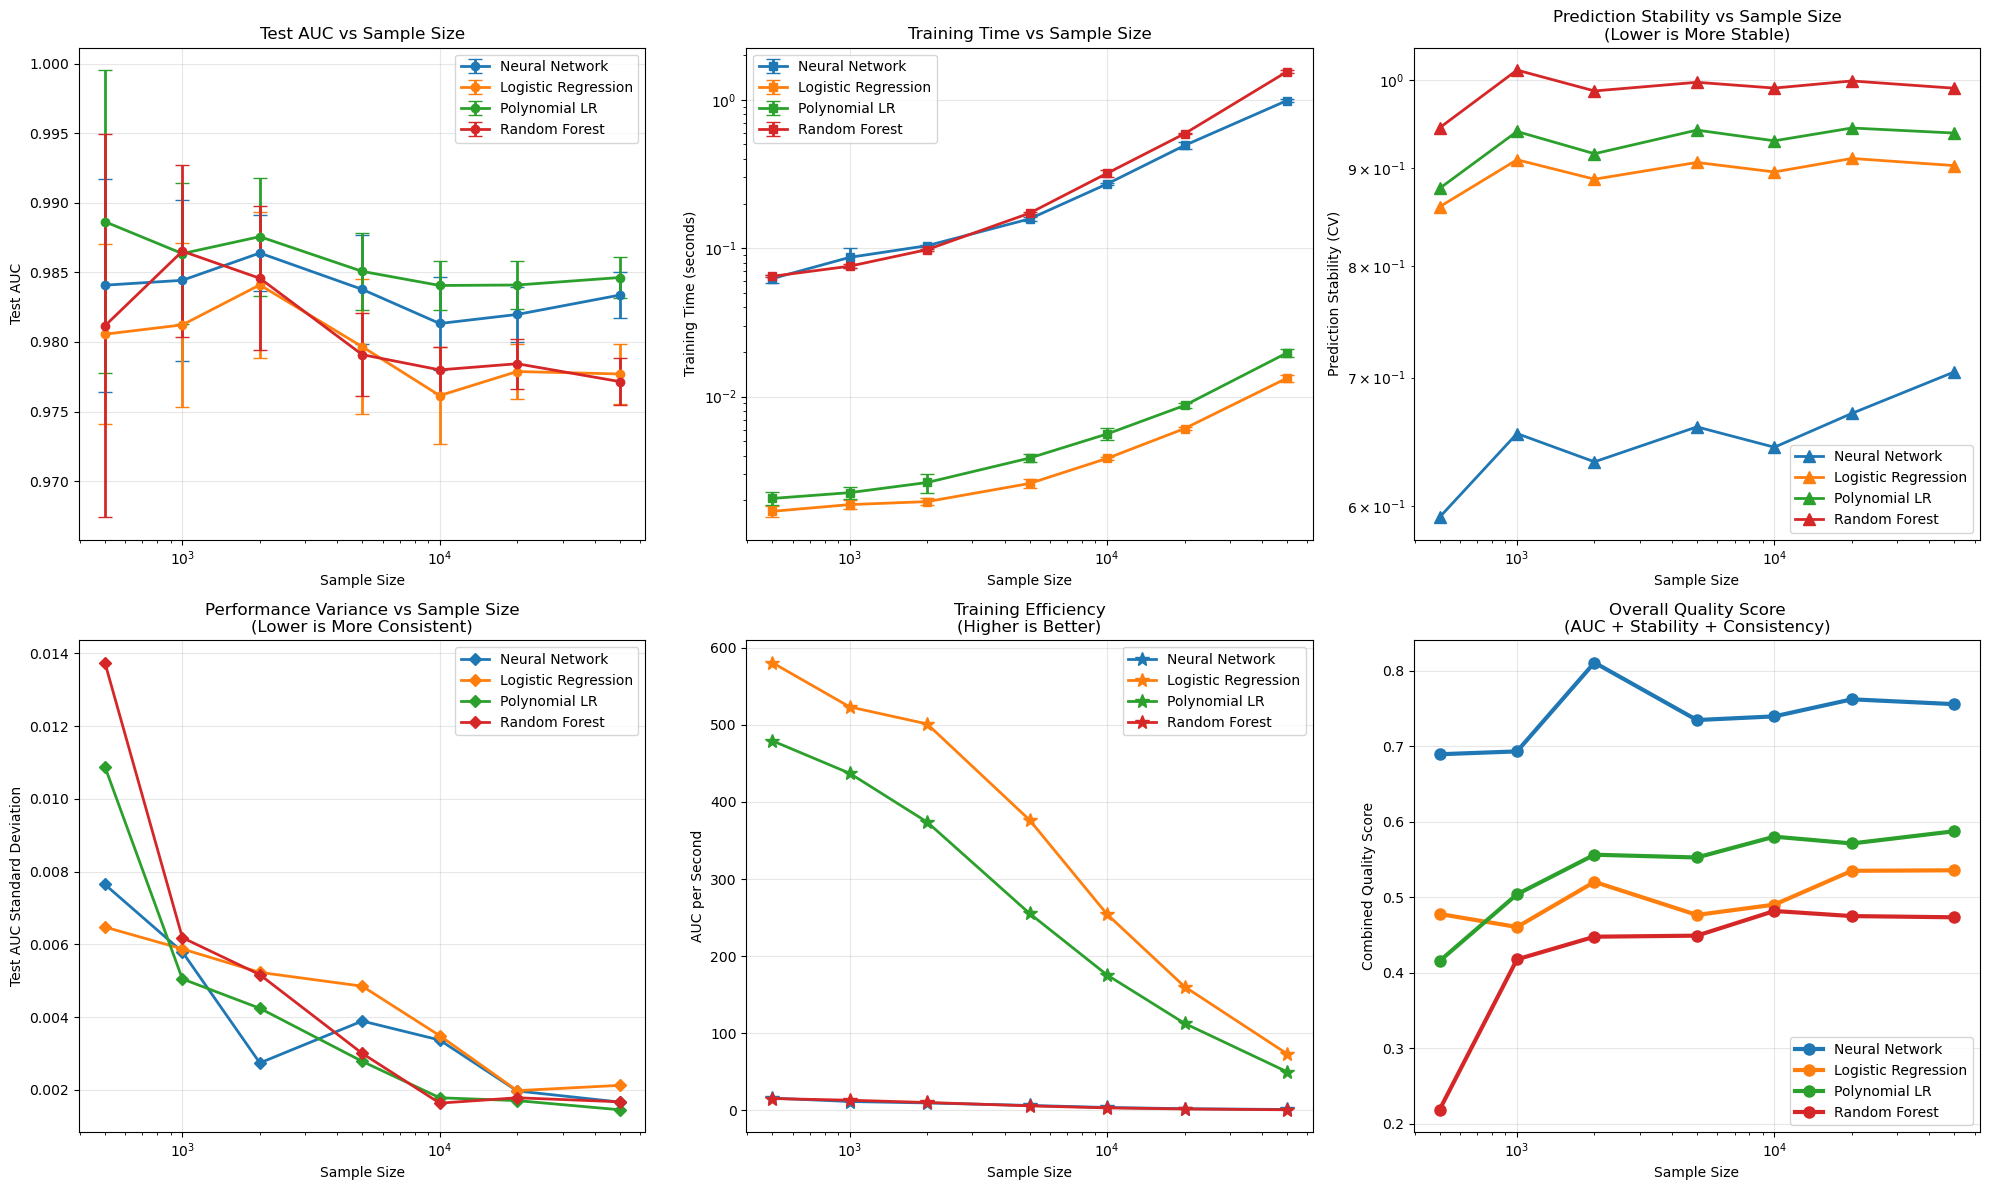


OPTIMAL SAMPLE SIZE RECOMMENDATIONS

Neural Network:
  Highest AUC: 0.9864 at sample size 2000
  Most stable: 0.5921 at sample size 500
  Most consistent: 0.0017 at sample size 50000
  Fastest training: 0.06s at sample size 500
  Diminishing returns after: 5000 samples

Logistic Regression:
  Highest AUC: 0.9841 at sample size 2000
  Most stable: 0.8589 at sample size 500
  Most consistent: 0.0020 at sample size 20000
  Fastest training: 0.00s at sample size 500
  Diminishing returns after: 5000 samples

Polynomial LR:
  Highest AUC: 0.9886 at sample size 500
  Most stable: 0.8780 at sample size 500
  Most consistent: 0.0015 at sample size 50000
  Fastest training: 0.00s at sample size 500
  Diminishing returns after: 5000 samples

Random Forest:
  Highest AUC: 0.9865 at sample size 1000
  Most stable: 0.9441 at sample size 500
  Most consistent: 0.0016 at sample size 10000
  Fastest training: 0.06s at sample size 500
  Diminishing returns after: 5000 samples

FINAL RECOMMENDATIONS

N

In [54]:
# Analyze and visualize the experimental results
print("Analyzing experimental results...")

# Convert results to DataFrame for easier analysis
exp_df = pd.DataFrame(results_dict)

# Calculate summary statistics by sample size and model type
summary_stats = exp_df.groupby(['sample_size', 'model_type']).agg({
    'test_auc': ['mean', 'std', 'min', 'max'],
    'test_ap': ['mean', 'std'],
    'training_time': ['mean', 'std'],
    'prediction_stability': 'mean'
}).round(4)

print("\nSUMMARY STATISTICS:")
print(summary_stats)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Test AUC vs Sample Size
for model_type in ['Neural Network', 'Logistic Regression', 'Polynomial LR', 'Random Forest']:
    model_data = exp_df[exp_df['model_type'] == model_type]
    auc_means = model_data.groupby('sample_size')['test_auc'].mean()
    auc_stds = model_data.groupby('sample_size')['test_auc'].std()
    
    axes[0, 0].errorbar(auc_means.index, auc_means.values, yerr=auc_stds.values, 
                       marker='o', label=model_type, capsize=5, linewidth=2)

axes[0, 0].set_xlabel('Sample Size')
axes[0, 0].set_ylabel('Test AUC')
axes[0, 0].set_title('Test AUC vs Sample Size')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xscale('log')

# 2. Training Time vs Sample Size
for model_type in ['Neural Network', 'Logistic Regression', 'Polynomial LR', 'Random Forest']:
    model_data = exp_df[exp_df['model_type'] == model_type]
    time_means = model_data.groupby('sample_size')['training_time'].mean()
    time_stds = model_data.groupby('sample_size')['training_time'].std()
    
    axes[0, 1].errorbar(time_means.index, time_means.values, yerr=time_stds.values, 
                       marker='s', label=model_type, capsize=5, linewidth=2)

axes[0, 1].set_xlabel('Sample Size')
axes[0, 1].set_ylabel('Training Time (seconds)')
axes[0, 1].set_title('Training Time vs Sample Size')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('log')
axes[0, 1].set_yscale('log')

# 3. Prediction Stability vs Sample Size
for model_type in ['Neural Network', 'Logistic Regression', 'Polynomial LR', 'Random Forest']:
    model_data = exp_df[exp_df['model_type'] == model_type]
    stability_means = model_data.groupby('sample_size')['prediction_stability'].mean()
    
    axes[0, 2].plot(stability_means.index, stability_means.values, 
                   marker='^', label=model_type, linewidth=2, markersize=8)

axes[0, 2].set_xlabel('Sample Size')
axes[0, 2].set_ylabel('Prediction Stability (CV)')
axes[0, 2].set_title('Prediction Stability vs Sample Size\n(Lower is More Stable)')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xscale('log')
axes[0, 2].set_yscale('log')

# 4. Performance Variance vs Sample Size
for model_type in ['Neural Network', 'Logistic Regression', 'Polynomial LR', 'Random Forest']:
    model_data = exp_df[exp_df['model_type'] == model_type]
    auc_vars = model_data.groupby('sample_size')['test_auc'].std()
    
    axes[1, 0].plot(auc_vars.index, auc_vars.values, 
                   marker='D', label=model_type, linewidth=2, markersize=6)

axes[1, 0].set_xlabel('Sample Size')
axes[1, 0].set_ylabel('Test AUC Standard Deviation')
axes[1, 0].set_title('Performance Variance vs Sample Size\n(Lower is More Consistent)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('log')

# 5. Efficiency Metric (AUC per Second)
for model_type in ['Neural Network', 'Logistic Regression', 'Polynomial LR', 'Random Forest']:
    model_data = exp_df[exp_df['model_type'] == model_type]
    auc_means = model_data.groupby('sample_size')['test_auc'].mean()
    time_means = model_data.groupby('sample_size')['training_time'].mean()
    efficiency = auc_means / time_means
    
    axes[1, 1].plot(efficiency.index, efficiency.values, 
                   marker='*', label=model_type, linewidth=2, markersize=10)

axes[1, 1].set_xlabel('Sample Size')
axes[1, 1].set_ylabel('AUC per Second')
axes[1, 1].set_title('Training Efficiency\n(Higher is Better)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xscale('log')

# 6. Combined Score (normalize and combine metrics)
nn_data = exp_df[exp_df['model_type'] == 'Neural Network']
lr_data = exp_df[exp_df['model_type'] == 'Logistic Regression']
plr_data = exp_df[exp_df['model_type'] == 'Polynomial LR']
rf_data = exp_df[exp_df['model_type'] == 'Random Forest']

for model_type, model_data in [('Neural Network', nn_data), ('Logistic Regression', lr_data), 
                              ('Polynomial LR', plr_data), ('Random Forest', rf_data)]:
    grouped = model_data.groupby('sample_size')
    
    # Normalize metrics (0-1 scale)
    auc_norm = (grouped['test_auc'].mean() - exp_df['test_auc'].min()) / (exp_df['test_auc'].max() - exp_df['test_auc'].min())
    stability_norm = 1 - ((grouped['prediction_stability'].mean() - exp_df['prediction_stability'].min()) / 
                         (exp_df['prediction_stability'].max() - exp_df['prediction_stability'].min()))
    variance_norm = 1 - ((grouped['test_auc'].std() - exp_df.groupby(['sample_size', 'model_type'])['test_auc'].std().min()) / 
                        (exp_df.groupby(['sample_size', 'model_type'])['test_auc'].std().max() - exp_df.groupby(['sample_size', 'model_type'])['test_auc'].std().min()))
    
    # Combined score (equal weights)
    combined_score = (auc_norm + stability_norm + variance_norm) / 3
    
    axes[1, 2].plot(combined_score.index, combined_score.values, 
                   marker='o', label=model_type, linewidth=3, markersize=8)

axes[1, 2].set_xlabel('Sample Size')
axes[1, 2].set_ylabel('Combined Quality Score')
axes[1, 2].set_title('Overall Quality Score\n(AUC + Stability + Consistency)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_xscale('log')

plt.tight_layout()
plt.show()

# Find optimal sample sizes
print("\n" + "="*60)
print("OPTIMAL SAMPLE SIZE RECOMMENDATIONS")
print("="*60)

for model_type in ['Neural Network', 'Logistic Regression', 'Polynomial LR', 'Random Forest']:
    model_data = exp_df[exp_df['model_type'] == model_type]
    grouped = model_data.groupby('sample_size')
    
    # Find sample size with best balance of metrics
    auc_means = grouped['test_auc'].mean()
    auc_stds = grouped['test_auc'].std()
    stability_means = grouped['prediction_stability'].mean()
    time_means = grouped['training_time'].mean()
    
    print(f"\n{model_type}:")
    print(f"  Highest AUC: {auc_means.max():.4f} at sample size {auc_means.idxmax()}")
    print(f"  Most stable: {stability_means.min():.4f} at sample size {stability_means.idxmin()}")
    print(f"  Most consistent: {auc_stds.min():.4f} at sample size {auc_stds.idxmin()}")
    print(f"  Fastest training: {time_means.min():.2f}s at sample size {time_means.idxmin()}")
    
    # Find "elbow" point where returns diminish
    auc_improvements = np.diff(auc_means.values) / auc_means.values[:-1]
    if len(auc_improvements) > 0:
        elbow_idx = np.argmin(auc_improvements) + 1
        if elbow_idx < len(sample_sizes):
            elbow_size = sample_sizes[elbow_idx]
            print(f"  Diminishing returns after: {elbow_size} samples")

# Print final recommendations
print(f"\n" + "="*60)
print("FINAL RECOMMENDATIONS")
print("="*60)

# Find best overall sample sizes for each model
for model_type in ['Neural Network', 'Logistic Regression', 'Polynomial LR', 'Random Forest']:
    model_data = exp_df[exp_df['model_type'] == model_type]
    grouped = model_data.groupby('sample_size')
    
    # Calculate composite score
    auc_norm = (grouped['test_auc'].mean() - 0.9) / 0.1  # Assume 0.9-1.0 range
    stability_inv = 1 / grouped['prediction_stability'].mean()  # Lower is better
    consistency_inv = 1 / grouped['test_auc'].std()  # Lower variance is better
    
    # Weight AUC more heavily, but consider efficiency
    composite_score = 0.5 * auc_norm + 0.3 * stability_inv + 0.2 * consistency_inv
    best_size = composite_score.idxmax()
    
    print(f"\n{model_type}:")
    print(f"  Recommended sample size: {best_size}")
    print(f"  Expected AUC: {grouped['test_auc'].mean()[best_size]:.4f} ± {grouped['test_auc'].std()[best_size]:.4f}")
    print(f"  Training time: {grouped['training_time'].mean()[best_size]:.2f}s")
    print(f"  Stability: {grouped['prediction_stability'].mean()[best_size]:.4f}")

print(f"\nNote: These recommendations balance performance, stability, and efficiency.")
print(f"For production use, consider computational constraints and required accuracy.")